<a href="https://colab.research.google.com/github/laritrevilato/fake_news_classification/blob/main/TCC_Larissa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade nltk
!pip install --upgrade numpy
!pip install --upgrade gensim
!pip install --upgrade pandas
!pip install --upgrade scipy
!pip install --upgrade scikit-learn
!pip install matplotlib
!pip install git-python

#scikit-learn

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
  Using cached nu

In [2]:
from nltk.tokenize import word_tokenize
import scipy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import nltk
import git


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
repo_dir_Fakebr = "/content/repo/Fakebr"
repo_Fakebr = "https://github.com/roneysco/Fake.br-Corpus.git"
diretorio_verdadeiras_Fakebr = "/content/repo/Fakebr/full_texts/true"
diretorio_falsas_Fakebr = "/content/repo/Fakebr/full_texts/fake"

repo_dir_FakeRecogna = "/content/repo/FakeRecogna"
repo_FakeRecogna = "https://github.com/Gabriel-Lino-Garcia/FakeRecogna.git"
file_name_FakeRecogna = 'repo/FakeRecogna/dataset/FakeRecogna.xlsx'

repo_dir_FakeTrue = "/content/repo/FakeTrue"
repo_FakeTrue = "https://github.com/jpchav98/FakeTrue.Br.git"
file_name_FakeTrue = '/content/repo/FakeTrue/FakeTrueBr_corpus.csv'

repo_dir_BoatosBR = "/content/repo/BoatosBR"
repo_BoatosBR =  "https://github.com/Felipe-Harrison/boatos-br-corpus.git"


In [4]:
if not os.path.exists(repo_dir_Fakebr):
  git.Repo.clone_from(repo_Fakebr,repo_dir_Fakebr)

if not os.path.exists(repo_dir_FakeRecogna):
  git.Repo.clone_from(repo_FakeRecogna,repo_dir_FakeRecogna)

if not os.path.exists(repo_dir_FakeTrue):
  git.Repo.clone_from(repo_FakeTrue,repo_dir_FakeTrue)

if not os.path.exists(repo_dir_BoatosBR):
  git.Repo.clone_from(repo_BoatosBR,repo_dir_BoatosBR)

In [5]:
def pre_processamento(texto):

  tokens = word_tokenize(texto)

  tokens = [token.lower() for token in tokens]

  stop_words = set(stopwords.words('portuguese'))
  tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  return ' '.join(tokens)

In [6]:
def read_FakeRecogna():

  df_FakeRecogna_raw = pd.read_excel(file_name_FakeRecogna)
  df_FakeRecogna_raw = df_FakeRecogna_raw[['Titulo', 'Subtitulo', 'Noticia', 'Classe']]

  # Convert the columns to strings before joining
  df_FakeRecogna_raw[['Titulo', 'Subtitulo', 'Noticia']] = df_FakeRecogna_raw[['Titulo', 'Subtitulo', 'Noticia']].astype(str)

  # Replace non-finite values with a suitable integer (e.g., -1)
  df_FakeRecogna_raw['Classe'] = df_FakeRecogna_raw['Classe'].fillna(-1).astype(int)

  df_FakeRecogna = pd.DataFrame({
      'FullText': df_FakeRecogna_raw[['Titulo', 'Subtitulo', 'Noticia']].agg(' '.join, axis=1),
      'Classe': df_FakeRecogna_raw['Classe']
  })

  df_FakeRecogna['FullText'] = df_FakeRecogna['FullText'].apply(pre_processamento)

  df_FakeRecogna_true = df_FakeRecogna[df_FakeRecogna['Classe'] == 1].copy()
  df_FakeRecogna_fake = df_FakeRecogna[df_FakeRecogna['Classe'] == 0].copy()

  return df_FakeRecogna_true, df_FakeRecogna_fake

In [7]:
def read_Fakebr():
  noticias_verdadeiras = []
  noticias_falsas = []

  for arquivo in os.listdir(diretorio_verdadeiras_Fakebr):
    with open(os.path.join(diretorio_verdadeiras_Fakebr, arquivo), 'r', encoding='utf-8') as f:
      texto = f.read()
      texto_processado = pre_processamento(texto)
      noticias_verdadeiras.append((texto_processado,1))

  for arquivo in os.listdir(diretorio_falsas_Fakebr):
    with open(os.path.join(diretorio_falsas_Fakebr, arquivo), 'r', encoding='utf-8') as f:
      texto = f.read()
      texto_processado = pre_processamento(texto)
      noticias_falsas.append((texto_processado,0))

  df_Fakebr_true = pd.DataFrame(noticias_verdadeiras, columns=['FullText', 'Classe'])
  df_Fakebr_fake = pd.DataFrame(noticias_falsas, columns=['FullText', 'Classe'])

  return df_Fakebr_true, df_Fakebr_fake

In [8]:
def read_FakeTrue():

  df_FakeTrue_raw = pd.read_csv(file_name_FakeTrue)

  # Convert the columns to strings before joining
  df_FakeTrue_raw[['title_fake', 'fake', 'true']] = df_FakeTrue_raw[['title_fake', 'fake', 'true']].astype(str)

  df_FakeTrue = pd.DataFrame({
      'Fake': df_FakeTrue_raw[['title_fake', 'fake']].agg(' '.join, axis=1),
      'True': df_FakeTrue_raw['true']
  })

  df_FakeTrue['Fake'] = df_FakeTrue['Fake'].apply(pre_processamento)
  df_FakeTrue['True'] = df_FakeTrue['True'].apply(pre_processamento)

  df_FakeTrue_true = pd.DataFrame({
      'FullText': df_FakeTrue['True'],
      'Classe': 1
  })

  df_FakeTrue_fake = pd.DataFrame({
      'FullText': df_FakeTrue['Fake'],
      'Classe': 0
  })
  return df_FakeTrue_true, df_FakeTrue_fake

In [9]:
def read_BoatosBR():
  file_name_BoatosBR = "/content/repo/BoatosBR/base_simples/boatos_br_corpus_simples.json"

  df_BoatosBR_raw = pd.read_json(file_name_BoatosBR)
  df_BoatosBR_raw = df_BoatosBR_raw[['texto','rotulo']]

  df_BoatosBR_true = df_BoatosBR_raw[df_BoatosBR_raw['rotulo'] == 'verdade'].copy()
  df_BoatosBR_fake = df_BoatosBR_raw[df_BoatosBR_raw['rotulo'] == 'falso'].copy()

  df_BoatosBR_true['texto'] = df_BoatosBR_true['texto'].apply(pre_processamento)
  df_BoatosBR_fake['texto'] = df_BoatosBR_fake['texto'].apply(pre_processamento)

  df_BoatosBR_true = pd.DataFrame({
      'FullText': df_BoatosBR_true['texto'],
      'Classe': 1
  })

  df_BoatosBR_fake = pd.DataFrame({
      'FullText': df_BoatosBR_fake['texto'],
      'Classe': 0
  })

  return df_BoatosBR_true, df_BoatosBR_fake


In [10]:
def BOW(noticias):
  lista_noticias = noticias['FullText']
  lista_rotulos = noticias['Classe']

  vectorizer = CountVectorizer()
  matriz_bow = vectorizer.fit_transform(lista_noticias)

  return matriz_bow, lista_rotulos

In [11]:
#TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfTransformer

def TFIDF(noticias):

    # Step 1: Extract the text and labels
    texts = noticias['FullText'].astype(str).tolist()
    labels = noticias['Classe'].tolist()

    # Step 2: Convert text to a count matrix
    vectorizer = CountVectorizer()
    count_matrix = vectorizer.fit_transform(texts)

    # Step 3: Apply TF-IDF transformation
    transformer = TfidfTransformer()
    tfidf_matrix = transformer.fit_transform(count_matrix)

    return tfidf_matrix, labels

In [50]:
#Word2Vec

import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def function_Word2Vec(noticias):

    vector_size=300
    window=10
    min_count=5

    # Step 1: Preprocess text
    noticias['FullText'] = noticias['FullText'].astype(str).str.lower()
    tokenized_texts = noticias['FullText'].apply(word_tokenize).tolist()

    # Step 2: Train Word2Vec model
    w2v_model = Word2Vec(

        sentences=tokenized_texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4
    )

    # Step 5: Compute document vectors (average of word vectors)
    def document_vector(doc):
        vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(vector_size)

    doc_vectors = np.array([document_vector(doc) for doc in tokenized_texts])

    # Apply MinMaxScaler to normalize document vectors
    scaler = MinMaxScaler()
    doc_vectors_normalized = scaler.fit_transform(doc_vectors)

    labels = noticias['Classe'].tolist()

    # Return the normalized document vectors along with the labels
    return doc_vectors_normalized, labels


In [ ]:
#df_FakeRecogna_true  --5951
#df_FakeRecogna_fake  --5951

#df_Fakebr_true       --3600
#df_Fakebr_fake       --3600

#df_FakeTrue_true     --1791
#df_FakeTrue_fake     --1791

#df_BoatosBR_true     --1516
#df_BoatosBR_fake     --1906 -- 1516

#full_data            --25716

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def function_SVC(x_train, y_train, x_test, y_test):
    # Cria o modelo SVC com kernel linear
    model = SVC(kernel='linear', C=1.0)

    # Treina o modelo
    model.fit(x_train, y_train)

    # Faz previsões
    y_pred = model.predict(x_test)

    # Calcula métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Retorna os resultados
    return {
        'modelo': model,
        'acuracia': accuracy,
        'precisao': precision,
        'revocacao': recall,
        'f1_score': f1,
        'matriz_confusao': conf_matrix
    }


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def function_LogisticRegression(x_train, y_train, x_test, y_test):
    # Inicializa o modelo de Regressão Logística
    model = LogisticRegression(max_iter=500)

    # Treina o modelo
    model.fit(x_train, y_train)

    # Realiza previsões
    y_pred = model.predict(x_test)

    # Calcula métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Retorna os resultados
    return {
        'modelo': model,
        'acuracia': accuracy,
        'precisao': precision,
        'revocacao': recall,
        'f1_score': f1,
        'matriz_confusao': conf_matrix
    }



In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def function_MultinomialNB(x_train, y_train, x_test, y_test):
    # Cria o modelo
    model = MultinomialNB(alpha=1.0)

    # Treina o modelo
    model.fit(x_train, y_train)

    # Faz previsões
    y_pred = model.predict(x_test)

    # Calcula métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Retorna resultados em um dicionário
    return {
        'modelo': model,
        'acuracia': accuracy,
        'precisao': precision,
        'revocacao': recall,
        'f1_score': f1,
        'matriz_confusao': conf_matrix
    }


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def function_RandomForest(x_train, y_train, x_test, y_test):
    # Inicializa o classificador Random Forest
    modelo = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    # Treina o modelo
    modelo.fit(x_train, y_train)

    # Realiza as previsões
    y_pred = modelo.predict(x_test)

    # Calcula métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Retorna os resultados
    return {
        'modelo': modelo,
        'acuracia': accuracy,
        'precisao': precision,
        'revocacao': recall,
        'f1_score': f1,
        'matriz_confusao': conf_matrix
    }


In [17]:
df_FakeRecogna_true, df_FakeRecogna_fake = read_FakeRecogna()

In [18]:
df_Fakebr_true, df_Fakebr_fake = read_Fakebr()

In [19]:
df_FakeTrue_true, df_FakeTrue_fake = read_FakeTrue()

In [20]:
df_BoatosBR_true, df_BoatosBR_fake = read_BoatosBR()
df_BoatosBR_fake = df_BoatosBR_fake.sample(n=1516, random_state=42).reset_index(drop=True)

In [36]:
def representation_method(method_name, dataframe):
    method_map = {
        'BOW': BOW,
        'TFIDF': TFIDF,
        'function_Word2Vec': function_Word2Vec
    }

    if method_name not in method_map:
        raise ValueError(f"Unknown method: {method_name}")

    # Call the appropriate function
    return {
        'representation_method': method_name,
        'representation': method_map[method_name](dataframe)
    }

In [37]:
from sklearn.model_selection import train_test_split

def process_classification_methods(representation, dataframe):
    # Obtém a representação dos dados
    result = representation_method(representation, dataframe)
    x_full, y_full = result["representation"]

    # Separa em treino e teste
    x_train, x_test, y_train, y_test = train_test_split(
        x_full,
        y_full,
        test_size=0.2,
        random_state=52,
        stratify=y_full
    )

    # Aplica os classificadores e coleta os resultados
    result_SVC = {
        'method_representation': representation,
        'method_classification': 'SVC',
        'result': function_SVC(x_train, y_train, x_test, y_test)
    }
    result_LR = {
        'method_representation': representation,
        'method_classification': 'LogisticRegression',
        'result': function_LogisticRegression(x_train, y_train, x_test, y_test)
    }
    result_MNB = {
        'method_representation': representation,
        'method_classification': 'MultinomialNB',
        'result': function_MultinomialNB(x_train, y_train, x_test, y_test)
    }
    result_RF = {
        'method_representation': representation,
        'method_classification': 'RandomForest',
        'result': function_RandomForest(x_train, y_train, x_test, y_test)
    }

    return [result_SVC, result_LR, result_MNB, result_RF]


In [23]:
def plot_model_comparison(
    results,
    representation_name,
    model_names,
    dataset_labels=None
):
    import matplotlib.pyplot as plt
    import numpy as np

    if dataset_labels is None:
        dataset_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']

    # Bar positions
    x = np.arange(len(model_names))
    width = 0.2  # Ajustado para 4 barras

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - 1.5*width, results[0], width, label=dataset_labels[0], color='lightcoral')
    bars2 = ax.bar(x - 0.5*width, results[1], width, label=dataset_labels[1], color='cornflowerblue')
    bars3 = ax.bar(x + 0.5*width, results[2], width, label=dataset_labels[2], color='turquoise')
    bars4 = ax.bar(x + 1.5*width, results[3], width, label=dataset_labels[3], color='mediumpurple')

    # Labels and formatting
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Model Accuracy: {representation_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1.05)
    ax.legend()

    # Add accuracy values above bars
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                yval + 0.01,
                f'{yval:.2f}',
                ha='center',
                va='bottom',
                fontsize=8
            )

    plt.tight_layout()
    plt.show()


In [24]:
data1 = pd.concat([df_Fakebr_true, df_Fakebr_fake], ignore_index=True)
data2 = pd.concat([df_FakeRecogna_true, df_FakeRecogna_fake], ignore_index=True)
data3 = pd.concat([df_FakeTrue_true, df_FakeTrue_fake], ignore_index=True)
data4 = pd.concat([df_BoatosBR_true, df_BoatosBR_fake], ignore_index=True)

In [25]:
full_data1 = pd.concat([
    df_Fakebr_true,
    df_Fakebr_fake
], ignore_index=True)

In [26]:
full_data2 = pd.concat([
    df_Fakebr_true,
    df_Fakebr_fake,
    df_FakeRecogna_true,
    df_FakeRecogna_fake
], ignore_index=True)

In [27]:
full_data3 = pd.concat([
    df_Fakebr_true,
    df_Fakebr_fake,
    df_FakeRecogna_true,
    df_FakeRecogna_fake,
    df_FakeTrue_true,
    df_FakeTrue_fake
], ignore_index=True)

In [28]:
full_data4 = pd.concat([
    df_Fakebr_true,
    df_Fakebr_fake,
    df_FakeRecogna_true,
    df_FakeRecogna_fake,
    df_FakeTrue_true,
    df_FakeTrue_fake,
    df_BoatosBR_true,
    df_BoatosBR_fake
], ignore_index=True)

In [56]:
results = []
representation_name = 'function_Word2Vec'
model_names = ['SVC', 'Logistic Regression', 'Multinomial NB', 'Random Forest']

result_fulldata1 = process_classification_methods(representation_name, full_data1)
results.append(result_fulldata1)
print(result_fulldata1)

[{'method_representation': 'function_Word2Vec', 'method_classification': 'SVC', 'result': {'modelo': SVC(kernel='linear'), 'acuracia': 0.8479166666666667, 'precisao': 0.8504320168493371, 'revocacao': 0.8479166666666667, 'f1_score': 0.8476432680364407, 'matriz_confusao': array([[580, 140],
       [ 79, 641]])}}, {'method_representation': 'function_Word2Vec', 'method_classification': 'LogisticRegression', 'result': {'modelo': LogisticRegression(max_iter=500), 'acuracia': 0.8381944444444445, 'precisao': 0.839089919173125, 'revocacao': 0.8381944444444445, 'f1_score': 0.8380875491197651, 'matriz_confusao': array([[585, 135],
       [ 98, 622]])}}, {'method_representation': 'function_Word2Vec', 'method_classification': 'MultinomialNB', 'result': {'modelo': MultinomialNB(), 'acuracia': 0.6916666666666667, 'precisao': 0.6917613636363636, 'revocacao': 0.6916666666666667, 'f1_score': 0.6916285961229781, 'matriz_confusao': array([[490, 230],
       [214, 506]])}}, {'method_representation': 'funct

In [57]:
results = []
representation_name = 'function_Word2Vec'
model_names = ['SVC', 'Logistic Regression', 'Multinomial NB', 'Random Forest']

result_fulldata2 = process_classification_methods(representation_name, full_data2)
results.append(result_fulldata2)
print(result_fulldata2)

[{'method_representation': 'function_Word2Vec', 'method_classification': 'SVC', 'result': {'modelo': SVC(kernel='linear'), 'acuracia': 0.862339701648783, 'precisao': 0.8647065844832377, 'revocacao': 0.862339701648783, 'f1_score': 0.8621142661579299, 'matriz_confusao': array([[1570,  340],
       [ 186, 1725]])}}, {'method_representation': 'function_Word2Vec', 'method_classification': 'LogisticRegression', 'result': {'modelo': LogisticRegression(max_iter=500), 'acuracia': 0.8594608741167233, 'precisao': 0.8604663842156124, 'revocacao': 0.8594608741167233, 'f1_score': 0.8593616369612788, 'matriz_confusao': array([[1591,  319],
       [ 218, 1693]])}}, {'method_representation': 'function_Word2Vec', 'method_classification': 'MultinomialNB', 'result': {'modelo': MultinomialNB(), 'acuracia': 0.7320073279246271, 'precisao': 0.7324385237227238, 'revocacao': 0.7320073279246271, 'f1_score': 0.7318853551444592, 'matriz_confusao': array([[1439,  471],
       [ 553, 1358]])}}, {'method_representati

In [58]:
results = []
representation_name = 'function_Word2Vec'
model_names = ['SVC', 'Logistic Regression', 'Multinomial NB', 'Random Forest']

result_fulldata3 = process_classification_methods(representation_name, full_data3)
results.append(result_fulldata3)
print(result_fulldata3)

[{'method_representation': 'function_Word2Vec', 'method_classification': 'SVC', 'result': {'modelo': SVC(kernel='linear'), 'acuracia': 0.84174564690324, 'precisao': 0.8424638490765157, 'revocacao': 0.84174564690324, 'f1_score': 0.8416616480386988, 'matriz_confusao': array([[1857,  411],
       [ 307, 1962]])}}, {'method_representation': 'function_Word2Vec', 'method_classification': 'LogisticRegression', 'result': {'modelo': LogisticRegression(max_iter=500), 'acuracia': 0.833810888252149, 'precisao': 0.8341463381355291, 'revocacao': 0.833810888252149, 'f1_score': 0.8337684426389743, 'matriz_confusao': array([[1855,  413],
       [ 341, 1928]])}}, {'method_representation': 'function_Word2Vec', 'method_classification': 'MultinomialNB', 'result': {'modelo': MultinomialNB(), 'acuracia': 0.7174344280361472, 'precisao': 0.7175101395825693, 'revocacao': 0.7174344280361472, 'f1_score': 0.717410787882105, 'matriz_confusao': array([[1648,  620],
       [ 662, 1607]])}}, {'method_representation': 

In [59]:
results = []
representation_name = 'function_Word2Vec'
model_names = ['SVC', 'Logistic Regression', 'Multinomial NB', 'Random Forest']

result_fulldata4 = process_classification_methods(representation_name, full_data4)
results.append(result_fulldata4)
print(result_fulldata4)

[{'method_representation': 'function_Word2Vec', 'method_classification': 'SVC', 'result': {'modelo': SVC(kernel='linear'), 'acuracia': 0.8460342146189735, 'precisao': 0.8474124821291438, 'revocacao': 0.8460342146189735, 'f1_score': 0.8458813583404592, 'matriz_confusao': array([[2095,  477],
       [ 315, 2257]])}}, {'method_representation': 'function_Word2Vec', 'method_classification': 'LogisticRegression', 'result': {'modelo': LogisticRegression(max_iter=500), 'acuracia': 0.8433125972006221, 'precisao': 0.8438323595527393, 'revocacao': 0.8433125972006221, 'f1_score': 0.8432533597552825, 'matriz_confusao': array([[2119,  453],
       [ 353, 2219]])}}, {'method_representation': 'function_Word2Vec', 'method_classification': 'MultinomialNB', 'result': {'modelo': MultinomialNB(), 'acuracia': 0.7220062208398134, 'precisao': 0.722028909784371, 'revocacao': 0.7220062208398134, 'f1_score': 0.7219991186716885, 'matriz_confusao': array([[1870,  702],
       [ 728, 1844]])}}, {'method_representat

In [11]:
results_word2vec = {
  "Base 1": {
    "Word2Vec": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.8479166666666667,
        "precisao": 0.8504320168493371,
        "revocacao": 0.8479166666666667,
        "f1_score": 0.8476432680364407,
        "matriz_confusao": [[580, 140], [79, 641]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=500)",
        "acuracia": 0.8381944444444445,
        "precisao": 0.839089919173125,
        "revocacao": 0.8381944444444445,
        "f1_score": 0.8380875491197651,
        "matriz_confusao": [[585, 135], [98, 622]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.6916666666666667,
        "precisao": 0.6917613636363636,
        "revocacao": 0.6916666666666667,
        "f1_score": 0.6916285961229781,
        "matriz_confusao": [[490, 230], [214, 506]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.8722222222222222,
        "precisao": 0.8723256460127813,
        "revocacao": 0.8722222222222222,
        "f1_score": 0.872213348149177,
        "matriz_confusao": [[634, 86], [98, 622]]
      }
    }
  },

  "Base 2": {
    "Word2Vec": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.862339701648783,
        "precisao": 0.8647065844832377,
        "revocacao": 0.862339701648783,
        "f1_score": 0.8621142661579299,
        "matriz_confusao": [[1570, 340], [186, 1725]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=500)",
        "acuracia": 0.8594608741167233,
        "precisao": 0.8604663842156124,
        "revocacao": 0.8594608741167233,
        "f1_score": 0.8593616369612788,
        "matriz_confusao": [[1591, 319], [218, 1693]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.7320073279246271,
        "precisao": 0.7324385237227238,
        "revocacao": 0.7320073279246271,
        "f1_score": 0.7318853551444592,
        "matriz_confusao": [[1439, 471], [553, 1358]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.8937450929076158,
        "precisao": 0.8937455535190114,
        "revocacao": 0.8937450929076158,
        "f1_score": 0.893745078352189,
        "matriz_confusao": [[1708, 202], [204, 1707]]
      }
    }
  },

  "Base 3": {
    "Word2Vec": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.84174564690324,
        "precisao": 0.8424638490765157,
        "revocacao": 0.84174564690324,
        "f1_score": 0.8416616480386988,
        "matriz_confusao": [[1857, 411], [307, 1962]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=500)",
        "acuracia": 0.833810888252149,
        "precisao": 0.8341463381355291,
        "revocacao": 0.833810888252149,
        "f1_score": 0.8337684426389743,
        "matriz_confusao": [[1855, 413], [341, 1928]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.7174344280361472,
        "precisao": 0.7175101395825693,
        "revocacao": 0.7174344280361472,
        "f1_score": 0.717410787882105,
        "matriz_confusao": [[1648, 620], [662, 1607]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.8840643597090588,
        "precisao": 0.884075242203606,
        "revocacao": 0.8840643597090588,
        "f1_score": 0.8840636162519979,
        "matriz_confusao": [[2011, 257], [269, 2000]]
      }
    }
  },

  "Base 4": {
    "Word2Vec": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.8460342146189735,
        "precisao": 0.8474124821291438,
        "revocacao": 0.8460342146189735,
        "f1_score": 0.8458813583404592,
        "matriz_confusao": [[2095, 477], [315, 2257]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=500)",
        "acuracia": 0.8433125972006221,
        "precisao": 0.8438323595527393,
        "revocacao": 0.8433125972006221,
        "f1_score": 0.8432533597552825,
        "matriz_confusao": [[2119, 453], [353, 2219]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.7220062208398134,
        "precisao": 0.722028909784371,
        "revocacao": 0.7220062208398134,
        "f1_score": 0.7219991186716885,
        "matriz_confusao": [[1870, 702], [728, 1844]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.8930793157076206,
        "precisao": 0.8931651380308266,
        "revocacao": 0.8930793157076206,
        "f1_score": 0.8930734805753684,
        "matriz_confusao": [[2278, 294], [256, 2316]]
      }
    }
  }
}

In [12]:
results_tfidf = {
  "Base 1": {
    "TFIDF": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.9625,
        "precisao": 0.9628571428571429,
        "revocacao": 0.9625,
        "f1_score": 0.9624927648080263,
        "matriz_confusao": [[703, 17], [37, 683]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=200)",
        "acuracia": 0.9548611111111112,
        "precisao": 0.9555016603209373,
        "revocacao": 0.9548611111111112,
        "f1_score": 0.9548452363895292,
        "matriz_confusao": [[701, 19], [46, 674]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.6131944444444445,
        "precisao": 0.7819107282693813,
        "revocacao": 0.6131944444444445,
        "f1_score": 0.545138772711729,
        "matriz_confusao": [[163, 557], [0, 720]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.9604166666666667,
        "precisao": 0.9611648140598463,
        "revocacao": 0.9604166666666667,
        "f1_score": 0.9604006061486163,
        "matriz_confusao": [[706, 14], [43, 677]]
      }
    }
  },
  "Base 2": {
    "TFIDF": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.9612666841141062,
        "precisao": 0.9612671789994325,
        "revocacao": 0.9612666841141062,
        "f1_score": 0.96126666819634,
        "matriz_confusao": [[1835, 75], [73, 1838]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=200)",
        "acuracia": 0.9458257000785135,
        "precisao": 0.9458268216369421,
        "revocacao": 0.9458257000785135,
        "f1_score": 0.9458256778151589,
        "matriz_confusao": [[1808, 102], [105, 1806]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.8272703480764197,
        "precisao": 0.858748680021047,
        "revocacao": 0.8272703480764197,
        "f1_score": 0.823388109502465,
        "matriz_confusao": [[1297, 613], [47, 1864]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.953415336299398,
        "precisao": 0.9536786351197938,
        "revocacao": 0.953415336299398,
        "f1_score": 0.9534087305898372,
        "matriz_confusao": [[1844, 66], [112, 1799]]
      }
    }
  },
  "Base 3": {
    "TFIDF": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.9493057086180295,
        "precisao": 0.9493228909587484,
        "revocacao": 0.9493057086180295,
        "f1_score": 0.9493052603926415,
        "matriz_confusao": [[2160, 108], [122, 2147]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=200)",
        "acuracia": 0.9336566012783778,
        "precisao": 0.9337094367833758,
        "revocacao": 0.9336566012783778,
        "f1_score": 0.9336546674249216,
        "matriz_confusao": [[2130, 138], [163, 2106]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.7987657042098303,
        "precisao": 0.8355297497646198,
        "revocacao": 0.7987657042098303,
        "f1_score": 0.7930886855069174,
        "matriz_confusao": [[1436, 832], [81, 2188]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.9385056204540445,
        "precisao": 0.9393771758031221,
        "revocacao": 0.9385056204540445,
        "f1_score": 0.9384754327368215,
        "matriz_confusao": [[2179, 89], [190, 2079]]
      }
    }
  },
  "Base 4": {
    "TFIDF": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.9537325038880249,
        "precisao": 0.9537327782463969,
        "revocacao": 0.9537325038880249,
        "f1_score": 0.953732496893888,
        "matriz_confusao": [[2452, 120], [118, 2454]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=200)",
        "acuracia": 0.9366251944012441,
        "precisao": 0.9366515973915399,
        "revocacao": 0.9366251944012441,
        "f1_score": 0.9366242363664619,
        "matriz_confusao": [[2419, 153], [173, 2399]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.8015163297045101,
        "precisao": 0.8403717016127753,
        "revocacao": 0.8015163297045101,
        "f1_score": 0.7956854106550817,
        "matriz_confusao": [[1627, 945], [76, 2496]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.9368195956454122,
        "precisao": 0.9375212636695018,
        "revocacao": 0.9368195956454122,
        "f1_score": 0.9367942543338261,
        "matriz_confusao": [[2461, 111], [214, 2358]]
      }
    }
  }
}


In [13]:
results_bow = {
  "Base 1": {
    "BOW": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.9715277777777778,
        "precisao": 0.9717325227963525,
        "revocacao": 0.9715277777777778,
        "f1_score": 0.9715246880086814,
        "matriz_confusao": [[707, 13], [28, 692]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=200)",
        "acuracia": 0.9722222222222222,
        "precisao": 0.9724008305609374,
        "revocacao": 0.9722222222222222,
        "f1_score": 0.9722195963738857,
        "matriz_confusao": [[707, 13], [27, 693]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.84375,
        "precisao": 0.8587021504012755,
        "revocacao": 0.84375,
        "f1_score": 0.8421045706340818,
        "matriz_confusao": [[534, 186], [39, 681]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.9479166666666666,
        "precisao": 0.9495199893137368,
        "revocacao": 0.9479166666666666,
        "f1_score": 0.9478701832411326,
        "matriz_confusao": [[704, 16], [59, 661]]
      }
    }
  },
  "Base 2": {
    "BOW": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.9489662392043967,
        "precisao": 0.9491349520658895,
        "revocacao": 0.9489662392043967,
        "f1_score": 0.9489615828473345,
        "matriz_confusao": [[1831, 79], [116, 1795]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=200)",
        "acuracia": 0.9617901073017535,
        "precisao": 0.9619041572546088,
        "revocacao": 0.9617901073017535,
        "f1_score": 0.9617878302861192,
        "matriz_confusao": [[1852, 58], [88, 1823]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.7330541742999215,
        "precisao": 0.7350097965057732,
        "revocacao": 0.7330541742999215,
        "f1_score": 0.7325026615013086,
        "matriz_confusao": [[1487, 423], [597, 1314]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.9502747971735148,
        "precisao": 0.9506623708504474,
        "revocacao": 0.9502747971735148,
        "f1_score": 0.9502643050548032,
        "matriz_confusao": [[1843, 67], [123, 1788]]
      }
    }
  },
  "Base 3": {
    "BOW": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.9435750495922416,
        "precisao": 0.9437739966646347,
        "revocacao": 0.9435750495922416,
        "f1_score": 0.9435688648823705,
        "matriz_confusao": [[2164, 104], [152, 2117]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=200)",
        "acuracia": 0.9537139078686356,
        "precisao": 0.9538848593129149,
        "revocacao": 0.9537139078686356,
        "f1_score": 0.9537096531278988,
        "matriz_confusao": [[2185, 83], [127, 2142]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.7577694511791933,
        "precisao": 0.7587724630115033,
        "revocacao": 0.7577694511791933,
        "f1_score": 0.7575369355096166,
        "matriz_confusao": [[1789, 479], [620, 1649]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.936742340753802,
        "precisao": 0.9375763200536334,
        "revocacao": 0.936742340753802,
        "f1_score": 0.93671251169816,
        "matriz_confusao": [[2174, 94], [193, 2076]]
      }
    }
  },
  "Base 4": {
    "BOW": {
      "SVC": {
        "modelo": "SVC(kernel='linear')",
        "acuracia": 0.9484836702954899,
        "precisao": 0.948576502366637,
        "revocacao": 0.9484836702954899,
        "f1_score": 0.9484810048554828,
        "matriz_confusao": [[2458, 114], [151, 2421]]
      },
      "LogisticRegression": {
        "modelo": "LogisticRegression(max_iter=200)",
        "acuracia": 0.9574261275272161,
        "precisao": 0.9574627096953658,
        "revocacao": 0.9574261275272161,
        "f1_score": 0.9574252763782233,
        "matriz_confusao": [[2474, 98], [121, 2451]]
      },
      "MultinomialNB": {
        "modelo": "MultinomialNB()",
        "acuracia": 0.7743001555209953,
        "precisao": 0.775103652092228,
        "revocacao": 0.7743001555209953,
        "f1_score": 0.7741352344418785,
        "matriz_confusao": [[2061, 511], [650, 1922]]
      },
      "RandomForest": {
        "modelo": "RandomForestClassifier(n_jobs=-1, random_state=42)",
        "acuracia": 0.9350699844479005,
        "precisao": 0.9359263928867219,
        "revocacao": 0.9350699844479005,
        "f1_score": 0.9350380788679865,
        "matriz_confusao": [[2462, 110], [224, 2348]]
      }
    }
  }
}

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_f1score(results_bow, results_tfidf, results_word2vec):
    metric = "f1_score"
    models = ["SVC", "LogisticRegression", "MultinomialNB", "RandomForest"]
    bases = ["Base 1", "Base 2", "Base 3", "Base 4"]

    def extract(source, rep_key, rep_label):
        rows = []
        for base in bases:
            base_data = source.get(base, {}).get(rep_key, {})
            for model in models:
                valor = base_data.get(model, {}).get(metric, 0)
                col_id = f"{model}_{rep_label}"
                rows.append({
                    "Base": base,
                    "Modelo_Representacao": col_id,
                    "F1-score": valor
                })
        return pd.DataFrame(rows)

    # Preparar dados
    df_bow = extract(results_bow, "BOW", "BoW")
    df_tfidf = extract(results_tfidf, "TFIDF", "TFIDF")
    df_w2v = extract(results_word2vec, "Word2Vec", "Word2Vec")
    df_all = pd.concat([df_bow, df_tfidf, df_w2v])

    # Pivotar para matriz Base x Modelo_Representacao
    df_pivot = df_all.pivot(index="Base", columns="Modelo_Representacao", values="F1-score")

    # Plotar heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(df_pivot, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={"label": "F1-score"})
    plt.title("Heatmap de F1-score por Modelo e Representação")
    plt.ylabel("Base de Dados")
    plt.xlabel("Modelo + Representação")
    plt.tight_layout()
    plt.show()


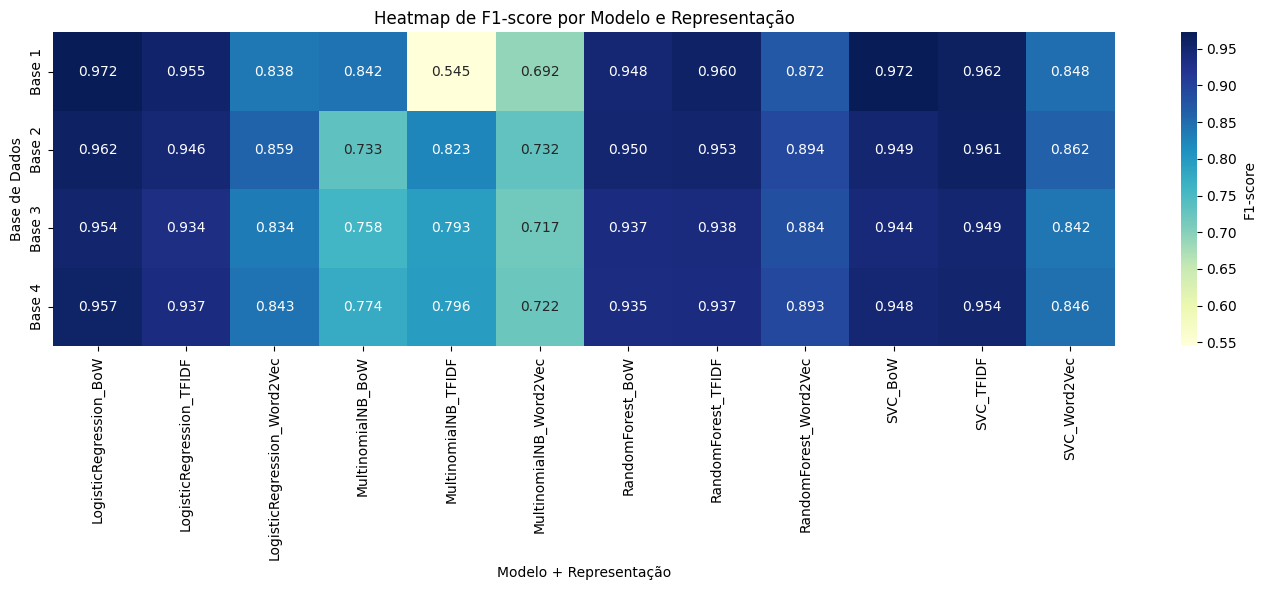

In [25]:
plot_heatmap_f1score(results_bow, results_tfidf, results_word2vec)


In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_vertical_por_metrica(results_bow, results_tfidf, results_word2vec, metrica="f1_score"):
    modelos = ["SVC", "LogisticRegression", "MultinomialNB", "RandomForest"]
    bases = ["Base 1", "Base 2", "Base 3", "Base 4"]

    def extract(source, rep_key, rep_label):
        rows = []
        for base in bases:
            base_data = source.get(base, {}).get(rep_key, {})
            for model in modelos:
                valor = base_data.get(model, {}).get(metrica, 0)
                row_id = f"{model}_{rep_label}"
                rows.append({
                    "Modelo_Representacao": row_id,
                    "Base": base,
                    "Valor": valor
                })
        return pd.DataFrame(rows)

    # Unir os dados
    df_bow = extract(results_bow, "BOW", "BoW")
    df_tfidf = extract(results_tfidf, "TFIDF", "TFIDF")
    df_w2v = extract(results_word2vec, "Word2Vec", "Word2Vec")
    df_all = pd.concat([df_bow, df_tfidf, df_w2v])

    # Pivotar: linhas = modelos + representação, colunas = base
    df_pivot = df_all.pivot(index="Modelo_Representacao", columns="Base", values="Valor")

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_pivot, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={"label": metrica.capitalize()})
    plt.title(f"Heatmap de {metrica.capitalize()} por Representação e Base")
    plt.xlabel("Base de Dados")
    plt.ylabel("Modelo + Representação")
    plt.tight_layout()
    plt.show()



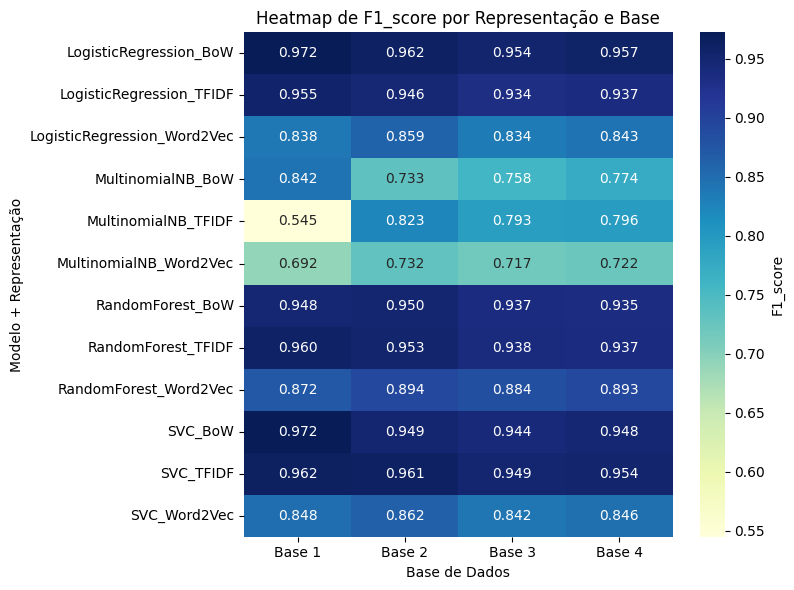

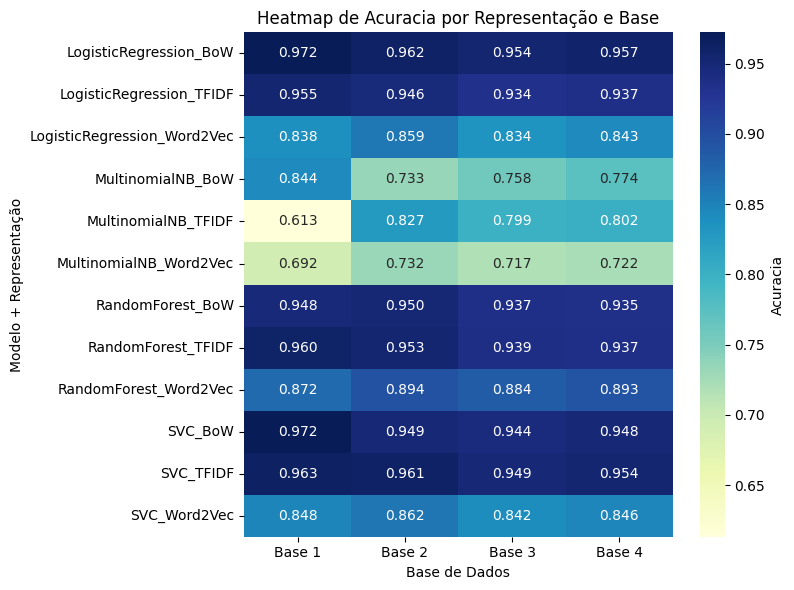

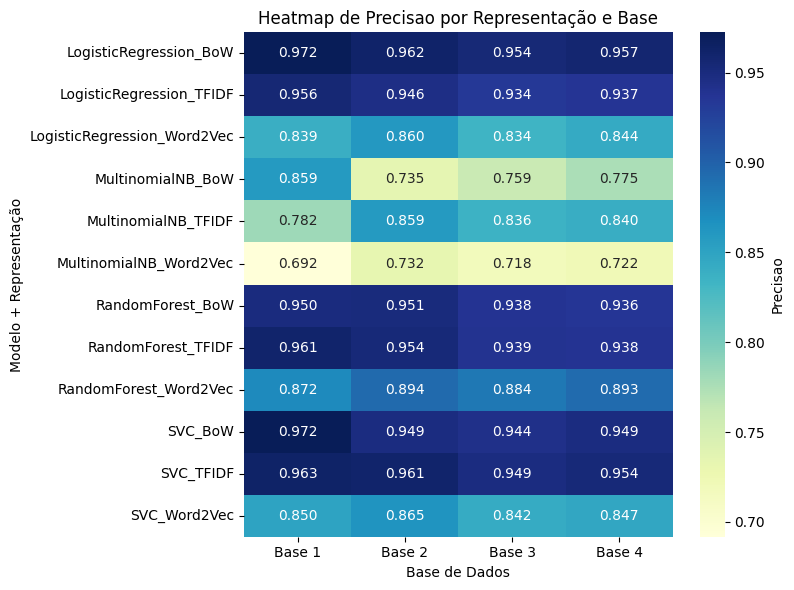

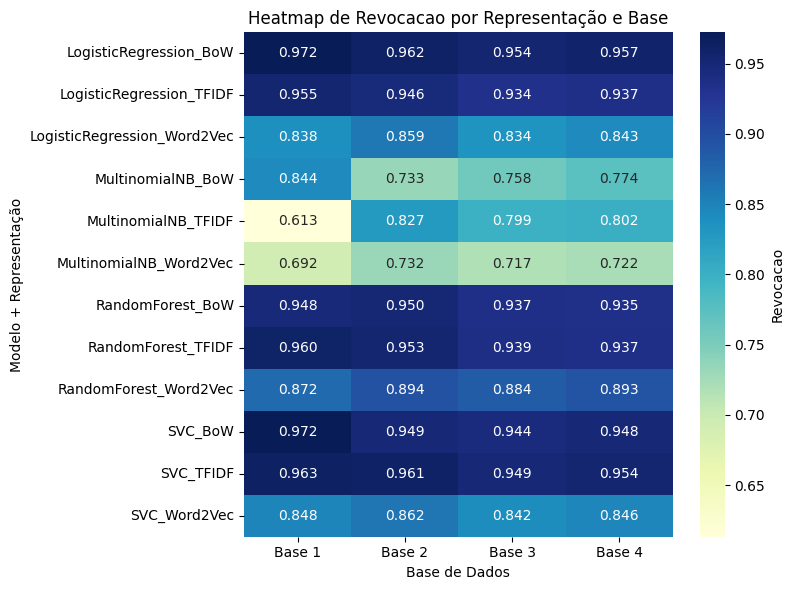

In [37]:
plot_heatmap_vertical_por_metrica(results_bow, results_tfidf, results_word2vec, metrica="f1_score")
plot_heatmap_vertical_por_metrica(results_bow, results_tfidf, results_word2vec, metrica="acuracia")
plot_heatmap_vertical_por_metrica(results_bow, results_tfidf, results_word2vec, metrica="precisao")
plot_heatmap_vertical_por_metrica(results_bow, results_tfidf, results_word2vec, metrica="revocacao")

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_f1score_per_base(results_bow, results_tfidf, results_word2vec):
    modelos = ["SVC", "LogisticRegression", "MultinomialNB", "RandomForest"]
    representacoes = {
        "BoW": (results_bow, "BOW"),
        "TF-IDF": (results_tfidf, "TFIDF"),
        "Word2Vec": (results_word2vec, "Word2Vec")
    }
    bases = ["Base 1", "Base 2", "Base 3", "Base 4"]

    for base in bases:
        f1_data = {rep_name: [] for rep_name in representacoes}

        for rep_name, (resultados, rep_key) in representacoes.items():
            base_data = resultados.get(base, {}).get(rep_key, {})
            for modelo in modelos:
                score = base_data.get(modelo, {}).get("f1_score", 0)
                f1_data[rep_name].append(score)

        # Preparação dos dados
        angles = np.linspace(0, 2 * np.pi, len(modelos), endpoint=False).tolist()
        angles += angles[:1]  # Fecha o círculo

        fig, ax = plt.subplots(figsize=(7, 6), subplot_kw=dict(polar=True))

        for rep_name, valores in f1_data.items():
            valores += valores[:1]  # Fecha o polígono
            ax.plot(angles, valores, label=rep_name)
            ax.fill(angles, valores, alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(modelos)
        ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax.set_yticklabels(["0.5", "0.6", "0.7", "0.8", "0.9", "1.0"])
        ax.set_ylim(0.5, 1.05)
        ax.set_title(f'Radar Plot - {base}', size=14, pad=20)
        ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
        plt.tight_layout()
        plt.show()


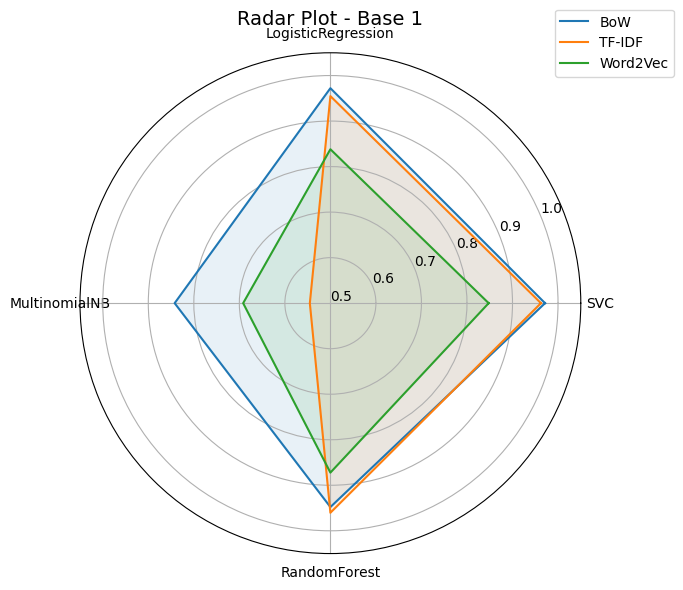

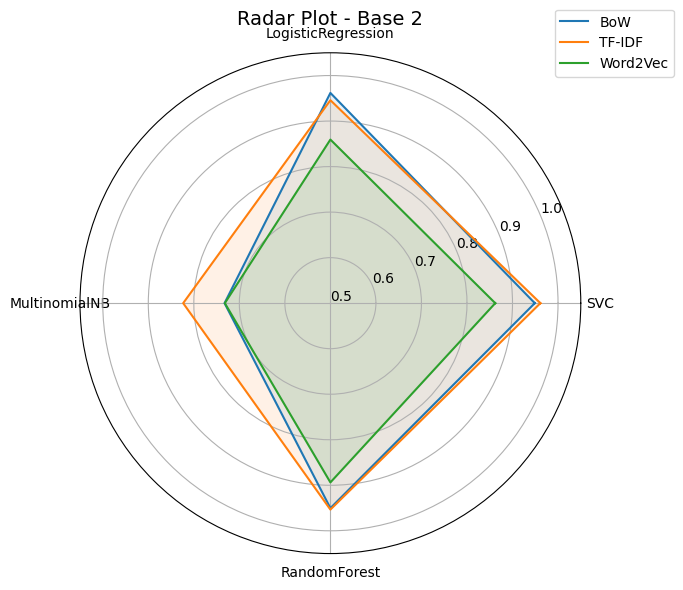

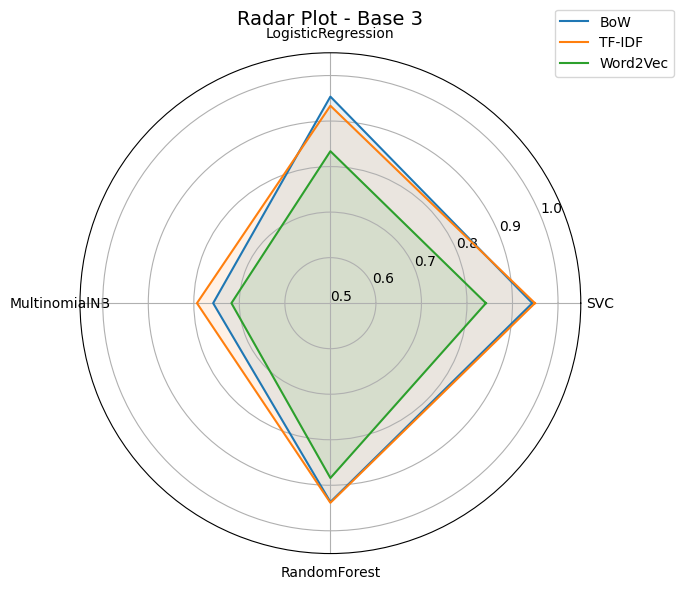

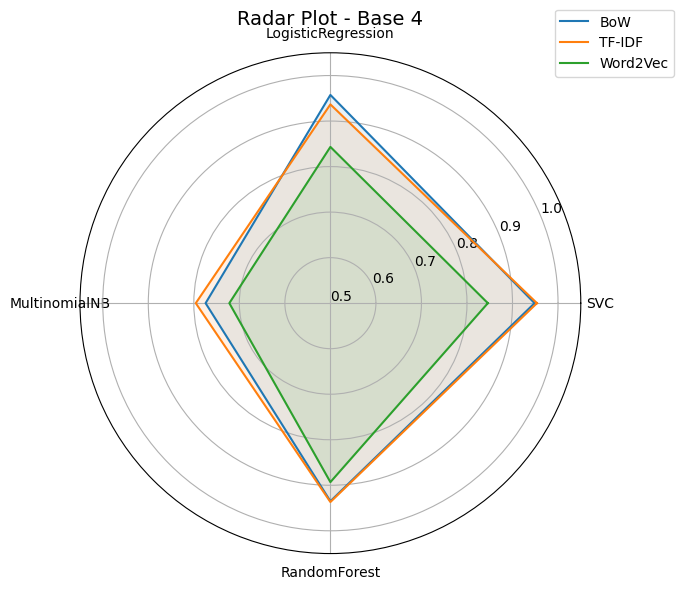

In [33]:
plot_radar_f1score_per_base(results_bow, results_tfidf, results_word2vec)

In [3]:
!git clone https://github.com/laritrevilato/fake_news_classification.git /content/fake_news_classification

Cloning into '/content/fake_news_classification'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 89.64 KiB | 1008.00 KiB/s, done.


In [4]:
%cd /content/fake_news_classification

/content/fake_news_classification
